# 01-Calibration

In [1]:
#Keefe changed Path to folder in the cell that makes the directory for the files 24 June 2020
#Keefe added the camera switch dates on 29 Jun 2020
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
from matplotlib.backends.backend_pdf import PdfPages
np.set_printoptions(linewidth=150)
import os

import pickle
from copy import copy
import matplotlib.colors as colors
from mpl_toolkits import mplot3d
from scipy.signal import find_peaks
%matplotlib inline

from math import modf

from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from scipy.sparse import csr_matrix

from astropy.convolution import convolve, Box1DKernel

from sara_spec import *

### The Following Cell will create the directory for all the files created in this notebook if it does nto already exist

In [2]:
# define the name of the directory to be created
folder = '01-CalibrationMasters'
try:
    os.mkdir(folder)
except OSError:
    print ('Creation of the directory %s failed (probably already exists' % folder)
else:
    print ('Successfully created the directory %s'  % folder)

Creation of the directory 01-CalibrationMasters failed (probably already exists


## Set the path to where the data is on your computer (or Google Drive)

In the cell below, you create a variable "path" that contains 
the direction to the directory that contains the raw data. 

We also set the dimension of the camera. 
* The variable "length" is in the dispersion direction (the long axis)
* The variable "width" is in the cross-dispersion direction (the short axis)

The way the SARA data are encoded, the cross dispersion is the first dimention. 

Thus a variable containing an image has dimension (510, 2108)

The region of the overscan (a small part of the detector that is not illuminated) is also defined here. Note that this changed with the camera switch. These regions are masked in the images -- the best place to see it is the Dark. If there is a region of low light that appears on the edges, it may be that the overscan is not set to the correct value. 

In [3]:
# Example of path for the raw data, and or 
#path = '/Users/keefekamp/FIT/SpectraTest/TestDataset'
path = '/Users/vpetit/Google Drive File Stream/Shared drives/REU2020-datasets/TestDataset/'


# For SARA KP dates before the camera switch ie before 2019-09-18
#left = 10
#right = 2060

# For SARA KP dates after the camera switch ie after 2019-12-06
left = 48
right = 2098

# For the SARA KP camera
length = 2108
width = 510

# Saving the overscan and lenght values for later use.
write_overscan(length, width, left, right)

## VP moved to module 
# np.savetxt( '01-CalibrationMasters/overscan.dat', np.array([length, width, left, right], dtype='int').T )

## VP moved to module
#cmap = copy(plt.cm.Reds)
#cmap.set_bad('purple', 1.0) # the masked values are masked (the 1 is for the alpha)

#cmap_sat = copy(plt.cm.Reds)
#cmap_sat.set_over('green', 1.0)
#cmap_sat.set_under('blue', 1.0)
#cmap_sat.set_bad('purple', 1.0) # the masked values are masked (the 1 is for the alpha)

## 1. Bias images

The goal of this cell is to create an array of file names (including the path) in the variable "all_filename" which will be used in the next cell. 


### 1.a The cell below will create a PDF of all the bias images, for inspection

The biases should look like this (you may have to add a scale factor in front of the "median")


Note that the region of the overscan (in purple) may vary depending on when the data was taken

At the end of this cell, you will also have a graph of the median of each image. It should be constant.

<img src="00-notebook-data/BiasExample.png" width="600">


### The cell below is an example for a case where the names only differ by a number. 

In "image_number", create an array with the number of the images that you want to check for the bias.

In the string adjust the name and format to match the filenames. 


### For other ways to create arrays of names in more complex situations 

e.g. when the names differ by more than just numbers), see video tutorial

In [ ]:
##########
# Cell to change
##########

image_number = np.arange(1,45,1)
print(image_number)

all_filename = ['{}/Bias/Bias-{:03}.fit'.format(path, item) for item in image_number]

#print(all_filename)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44]


(1248.6666666666667, 2824.5)

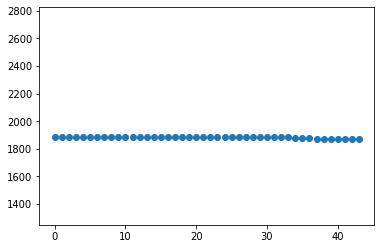

In [ ]:
# Nothing to change in this cell

image_median = []
with PdfPages('01-CalibrationMasters/Bias.pdf') as pdf:

    for name in all_filename:
        data = ma.array(fits.getdata(name))
        data[:,0:left] = ma.masked
        data[:,right:length]=ma.masked
    
        fig, ax = plt.subplots(1,1, figsize=(10,5))
        img = ax.imshow(data, origin = 'lower', cmap=cmap, aspect='auto',
                        vmin=1*ma.min(data),vmax = 1*ma.max(data))
        ax.set_title(name)
        plt.colorbar(img,extend='both')
        pdf.savefig(fig)
        plt.close()
        image_median.append(ma.median(data))

image_median = np.array(image_median)
fig, ax = plt.subplots(1,1)
ax.scatter( np.arange(0,image_median.size,1), image_median )
ax.set_ylim(np.min(image_median)/1.5, np.max(image_median)*1.5)

## Add labels to the figure below

### 1.b Now that you have inspected all the biases, make a finale selection below

The cell will use the list of filenames in "all_filename_final" to create the Master Bias. 

The example here is constructed for names with only a different number. For more complex case, see the tutorials. 

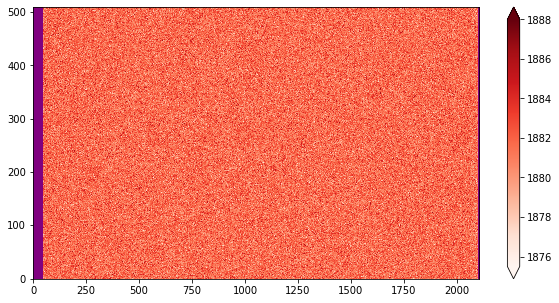

In [ ]:
output_name='01-CalibrationMasters/MasterBias'

image_number_final = np.arange(1,45,1)
all_filename_final = ['{}/Bias/Bias-{:03}.fit'.format(path, item) for item in image_number_final]

##############
##############
# Nothing to change below


data = np.ndarray(shape=(len(all_filename_final),width, length))

for i,name in enumerate(all_filename_final):
    data[i] = ma.array(fits.getdata(name))
    data[i,:,0:left] = ma.masked
    data[i,:,right:length]=ma.masked

median_val = ma.median(data, 0)

## remasking the array:
median_val[:,0:left] = ma.masked
median_val[:,right:length] = ma.masked

median_val.dump('{}.dump'.format(output_name))

fig, ax = plt.subplots(1,1, figsize=(10,5))
img = ax.imshow(median_val, origin = 'lower', cmap=cmap, aspect='auto',
                vmin=ma.min(median_val),vmax = ma.max(median_val))
plt.colorbar(img,extend='both')


## 2. Darks

The darks should ultimately be grouped by exposure times. 

### 2a.The cell below will create a PDF of all the dark images, for inspection

The darks should look like this (you may have to add a scale factor in front of the "median")

<img src="00-notebook-data/DarkExample.png" width="600">

The goal of the cell below is to create a variable "all_filename" with the names of all the dark images

In [ ]:
##########
# Cell to change
##########

image_number = np.arange(1,6,1)
print(image_number)

all_filename = ['{}/Dark/Dark-{:03}.fit'.format(path, item) for item in image_number]

#print(all_filename)

[1 2 3 4 5]


The cell below will take your result and create the graphs

(1664.0, 3756.0)

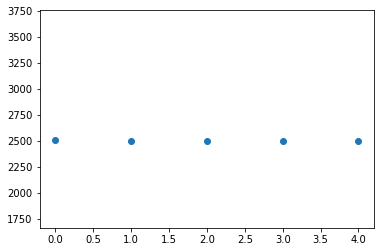

In [ ]:
# Nothing to change in this cell
image_median = []
with PdfPages('01-CalibrationMasters/Dark-all.pdf') as pdf:

    for name in all_filename:
        data = ma.array(fits.getdata(name))
        #data[:,0:left] = ma.masked
        #data[:,right:length]=ma.masked
    
        fig, ax = plt.subplots(1,1, figsize=(10,5))
        img = ax.imshow(data, origin = 'lower', cmap=cmap, aspect= 'auto',
                        vmin=ma.min(data), vmax = ma.median(data)+3*ma.std(data))
        ax.set_title(name)
        plt.colorbar(img, extend='both')
        pdf.savefig(fig)
        plt.close()
        image_median.append(ma.median(data))

image_median = np.array(image_median)

fig, ax = plt.subplots(1,1)
ax.scatter( np.arange(0,image_median.size,1), image_median )
ax.set_ylim(np.min(image_median)/1.5, np.max(image_median)*1.5)

## Add labels to the figure below

### 2.b Now that you have inspected all the darks, make a finale selection below

Note: you will have to execute the cell below for each exposure time group. 

Please add the exposure time in the output name for the dark.

Keep all of the commands you've use (commented out) for the records

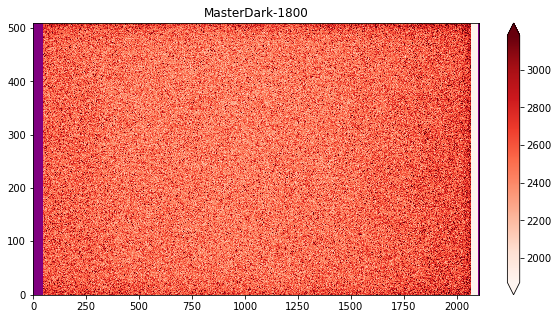

In [ ]:
output_name='MasterDark-1800'
image_number_final = np.arange(1,6,1)
all_filename_final = ['{}/Dark/Dark-{:03}.fit'.format(path, item) for item in image_number_final]


##############
##############
# Nothing to change below

with PdfPages('01-CalibrationMasters/{}.pdf'.format(output_name)) as pdf:

    data = np.ndarray(shape=(len(all_filename_final),width, length))

    for i,name in enumerate(all_filename_final):
        data[i] = ma.array(fits.getdata(name))
        data[:,:,0:left] = ma.masked
        data[:,:,right:length]=ma.masked

    median_val = ma.median(data, 0)

    ## remasking the array:
    median_val[:,0:left] = ma.masked
    median_val[:,right:length] = ma.masked

    median_val.dump('01-CalibrationMasters/{}.dump'.format(output_name) )

    fig, ax = plt.subplots(1,1, figsize=(10,5))
    img = ax.imshow(median_val, origin = 'lower', cmap=cmap, aspect='auto',
                            vmin=ma.min(median_val), vmax = ma.median(median_val)+3*ma.std(median_val))
    ax.set_title(output_name)
    plt.colorbar(img, extend='both')

    pdf.savefig(fig)
    plt.show()
    plt.close()

    #################
    #This part created an unmasked array for the dark database

    # Get the header of the first file in the list for the resulting fits file
    header = fits.getheader(all_filename_final[0])
    # Reading the first file to get size
    data1 = fits.getdata(all_filename_final[0])

    # Create an empty array for subsequently taking the median
    data = np.ndarray(shape=(len(all_filename_final), data1.shape[0], data1.shape[1]))
    # Create an empty array for the median of each images (to make sure everything is OK)
    image_median = []

    fig, ax = plt.subplots(1,1, figsize=(10,4))

    for i,name in enumerate(all_filename_final):
        data[i] = np.array(fits.getdata(name))
        ax.plot( np.arange(0,data1.shape[0]), data[i,:,1000] )
        image_median.append(np.median(data[i]))

    pdf.savefig(fig)
    plt.close()

    # Calculate the median image
    median_val = np.median(data, 0)

    # Writting the file as fits
    fits.writeto( '01-CalibrationMasters/{}.fits'.format(output_name), median_val, header=header,overwrite=True )

    # Make a graph of the median of each images
    image_median = np.array(image_median)
    fig, ax = plt.subplots(1,1)
    ax.scatter( np.arange(0,image_median.size,1), image_median )
    ax.set_ylim(np.min(image_median)/1.5, np.max(image_median)*1.5)
    ax.set_xlabel('Image #')
    ax.set_ylabel('Image median')
    pdf.savefig(fig)
    plt.close()


    # Make an image of the median Dark
    fig, ax = plt.subplots(1,1, figsize=(10,5))
    img = ax.imshow(median_val, origin = 'lower', cmap='Reds', aspect='auto',
                            vmin=ma.min(median_val), vmax = ma.median(median_val)+3*ma.std(median_val))
    ax.set_title('Median Dark for Dark database')
    plt.colorbar(img, extend='both')

    pdf.savefig(fig)
    plt.close()


## 3. Flats 

We need to subtract the Master Bias from the flats, before we combine them. 

## 3.a The cell below will create a PDF of all the FLATS for inspection

Flat images should look like this:

<img src="00-notebook-data/FlatExample.png" width="600">

In [ ]:
##########
# Cell to change
##########

image_number = np.arange(1,23,1)
print(image_number)
all_filename = ['{}/Flat/Flat-{:03}.fit'.format(path, item) for item in image_number]

#print(all_filename)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]


(1327.0, 4910.25)

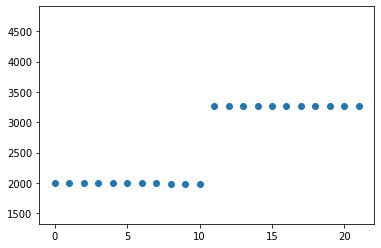

In [ ]:
toSubtract = np.load('01-CalibrationMasters/MasterBias.dump', allow_pickle=True)

### this line loads masterBias into the toSubtract variable. 
### make sure you have the right filename
###################
# nothing to change below

image_median = []
with PdfPages('01-CalibrationMasters/Flat_all.pdf') as pdf:

    for name in all_filename:
        data = ma.array(fits.getdata(name))-toSubtract ## this is where the subtraction is
        data[:,0:left] = ma.masked
        data[:,right:length]=ma.masked
    
        fig, ax = plt.subplots(1,1, figsize=(10,5))
        img = ax.imshow(data, origin = 'lower', cmap=cmap, aspect= 'auto',
                        vmin=ma.min(data), vmax = ma.median(data)+3*ma.std(data))
        ax.set_title(name)
        plt.colorbar(img, extend='both')
        pdf.savefig(fig)
        plt.close()
        image_median.append(ma.median(data))

image_median = np.array(image_median)

fig, ax = plt.subplots(1,1)
ax.scatter( np.arange(0,image_median.size,1), image_median )
ax.set_ylim(np.min(image_median)/1.5, np.max(image_median)*1.5)

## Add labels to the figure below

## 3.b Now that you have inspected all the flats, as long as they are okay,  make a finale selection below and create Master file for each exposure times

Note: you will have to execute the cell below for each exposure time group. 

Please add the exposure time in the output name for the flat.

Keep all of the commands you've use (commented out) for the records

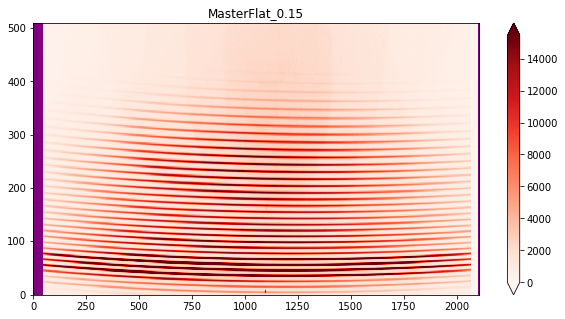

In [ ]:
toSubtract = np.load('01-CalibrationMasters/MasterBias.dump', allow_pickle=True)
# Make sure the the file name is still right:


output_name='MasterFlat_0.15'
image_number_final = np.arange(1,12,1) 
all_filename_final = ['{}/Flat/Flat-{:03}.fit'.format(path, item) for item in image_number_final]

#output_name='MasterFlat_0.25'
#image_number_final = np.arange(12,23,1) 
#all_filename_final = ['{}/Flat/Flat-{:03}.fit'.format(path, item) for item in image_number_final]


##############
##############
# nothing to change below

data = np.ndarray(shape=(len(all_filename_final),width, length))

for i,name in enumerate(all_filename_final):
    data[i] = ma.array(fits.getdata(name))-toSubtract ## this is where the subtraction is
    data[:,:,0:left] = ma.masked
    data[:,:,right:length]=ma.masked

median_val = ma.median(data, 0)

## remasking the array:
median_val[:,0:left] = ma.masked
median_val[:,right:length] = ma.masked

median_val.dump('01-CalibrationMasters/{}.dump'.format(output_name) )

with PdfPages('01-CalibrationMasters/{}.pdf'.format(output_name)) as pdf:

    fig, ax = plt.subplots(1,1, figsize=(10,5))
    img = ax.imshow(median_val, origin = 'lower', cmap=cmap, aspect='auto',
                            vmin=ma.min(median_val), vmax = ma.median(median_val)+3*ma.std(median_val))
    ax.set_title(output_name)
    plt.colorbar(img, extend='both')
    plt.show()
    pdf.savefig(fig)
    plt.close()

    

## 4. THARs 

## 4.a The cell below will create a PDF of all the ThAr for inspection

ThAr images should look like this:

<img src="00-notebook-data/ThArExample.png" width="600">

The cell below creates an array with the filenames of all the ThAr. 

In [ ]:
##########
# Cell to change
##########

image_number = np.arange(1,16,1) 
early_filename = ['{}/ThAr/early/Th-Ar-{:03}.fit'.format(path, item) for item in image_number]

image_number = np.arange(1,12,1) 
late_filename=['{}/ThAr/late/Th-Ar-2nd-{:03}.fit'.format(path, item) for item in image_number]

all_filename=early_filename+late_filename
                
#print(all_filename)

The cell below creates a PDF with an image of all the ThAr

(28.666666666666668, 110.25)

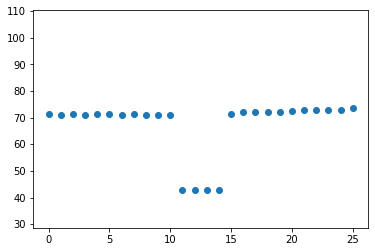

In [ ]:
toSubtract = np.load('01-CalibrationMasters/MasterBias.dump', allow_pickle=True)
# Make sure the the file name is still right:


##############
##############
# nothing to change below

image_median = []
with PdfPages('01-CalibrationMasters/ThAr_all.pdf') as pdf:

    for name in all_filename:
        data = ma.array(fits.getdata(name))-toSubtract 
        data[:,0:left] = ma.masked
        data[:,right:length]=ma.masked
    
        fig, ax = plt.subplots(1,1, figsize=(10,5))
        img = ax.imshow(data, origin = 'lower', cmap=cmap, aspect= 'auto',
                        vmin=ma.min(data), vmax = ma.median(data)+3*ma.std(data))
        ax.set_title(name)
        plt.colorbar(img, extend='both')
        pdf.savefig(fig)
        plt.close()
        image_median.append(ma.median(data))

image_median = np.array(image_median)

fig, ax = plt.subplots(1,1)
ax.scatter( np.arange(0,image_median.size,1), image_median )
ax.set_ylim(np.min(image_median)/1.5, np.max(image_median)*1.5)

## Add labels to the figure below

## 5.b Now that you have inspected all the ThArs, as long as they are okay,  make a finale selection below and create Master file

Note: you will have to execute the cell below for each exposure time group. 

Keep all of the commands you've use (commented out) for the records


['/Users/keefekamp/FIT/SpectraTest/TestDataset/ThAr/early/Th-Ar-001.fit', '/Users/keefekamp/FIT/SpectraTest/TestDataset/ThAr/early/Th-Ar-002.fit', '/Users/keefekamp/FIT/SpectraTest/TestDataset/ThAr/early/Th-Ar-003.fit', '/Users/keefekamp/FIT/SpectraTest/TestDataset/ThAr/early/Th-Ar-004.fit', '/Users/keefekamp/FIT/SpectraTest/TestDataset/ThAr/early/Th-Ar-005.fit', '/Users/keefekamp/FIT/SpectraTest/TestDataset/ThAr/early/Th-Ar-006.fit', '/Users/keefekamp/FIT/SpectraTest/TestDataset/ThAr/early/Th-Ar-007.fit', '/Users/keefekamp/FIT/SpectraTest/TestDataset/ThAr/early/Th-Ar-008.fit', '/Users/keefekamp/FIT/SpectraTest/TestDataset/ThAr/early/Th-Ar-009.fit', '/Users/keefekamp/FIT/SpectraTest/TestDataset/ThAr/early/Th-Ar-010.fit', '/Users/keefekamp/FIT/SpectraTest/TestDataset/ThAr/late/Th-Ar-2nd-001.fit', '/Users/keefekamp/FIT/SpectraTest/TestDataset/ThAr/late/Th-Ar-2nd-002.fit', '/Users/keefekamp/FIT/SpectraTest/TestDataset/ThAr/late/Th-Ar-2nd-003.fit', '/Users/keefekamp/FIT/SpectraTest/TestDat

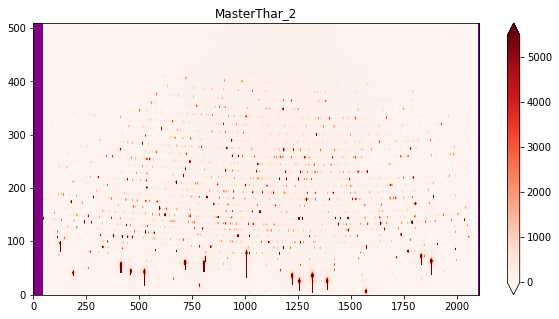

In [ ]:
toSubtract = np.load('01-CalibrationMasters/MasterBias.dump', allow_pickle=True)
# Make sure the the file name is still right:

#output_name='MasterThAr_1'
#all_filename_final = ['{}ThAr-Spec-20200113-{:03}.fit'.format(path, item) for item in range(1,6)]

#output_name='MasterThAr_2'
#all_filename_final = ['{}ThAr-Spec-20200113-{:03}.fit'.format(path, item) for item in range(6,11)]

#output_name='MasterThAr_3'
#all_filename_final = ['{}ThAr-Spec-20200113-{:03}.fit'.format(path, item) for item in range(11,16)]

#output_name='MasterThAr_4'
#all_filename_final = ['{}ThAr-Spec-20200113-{:03}.fit'.format(path, item) for item in range(16,21)]

#output_name='MasterThAr_5'
#all_filename_final = ['{}ThAr-Spec-20200113-{:03}.fit'.format(path, item) for item in range(21,26)]

output_name='MasterThAr_6'
all_filename_final = ['{}ThAr-Spec-20200113-{:03}.fit'.format(path, item) for item in range(26,31)]


####create the above code for Thars taken in the same time frame
###apply that piece of code to all of them in the same cell five times

#############

data = np.ndarray(shape=(len(all_filename_final),width, length))

for i,name in enumerate(all_filename_final):
    data[i] = ma.array(fits.getdata(name))-toSubtract 
    data[:,:,0:left] = ma.masked
    data[:,:,right:length]=ma.masked
    
    
median_val = ma.median(data, 0)

## remasking the array:
median_val[:,0:left] = ma.masked
median_val[:,right:length] = ma.masked

median_val.dump('01-CalibrationMasters/{}.dump'.format(output_name))

with PdfPages('01-CalibrationMasters/{}.pdf'.format(output_name)) as pdf:

    fig, ax = plt.subplots(1,1, figsize=(10,5))
    img = ax.imshow(median_val, origin = 'lower', cmap=cmap, aspect='auto',
                            vmin=ma.min(median_val), vmax = ma.median(median_val)+3*ma.std(median_val))
    ax.set_title(output_name)
    plt.colorbar(img, extend='both')
    plt.show()
    pdf.savefig(fig)
    plt.close()
